Imports and set-up

In [14]:
# makes figures interactable
%matplotlib notebook

# reloads changes to external files without restarting the notebook
%load_ext autoreload
%autoreload 2

#import math and plotting tools
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng()

#import brain area module
from brain import BrainArea

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Define parameters of the model and instantiate a brain area and 10 stimuli (5 per area)

In [15]:
n_inputs = 1000
n_neurons = 1000
cap_size = 30
density = 0.2
n_areas = 2

seq_len = 5
stimulus = np.zeros((n_areas, seq_len, n_inputs))
for i in range(seq_len * n_areas):
    stimulus[i // seq_len, i % seq_len, i*cap_size : (i+1)*cap_size] = 1.

areas = [BrainArea([n_inputs, n_neurons], n_neurons, cap_size, density, plasticity=1e-1, norm_init=True) for _ in range(n_areas)]

Form assemblies for each stimulus in the associated brain area (alternatively, skip this step to make learning the sequence easier)

In [18]:
n_rounds = 25

outputs_form = np.zeros((n_areas, n_rounds, seq_len, n_neurons))
for k, area in enumerate(areas):
    for j in range(seq_len):
        area.inhibit()
        for i in range(n_rounds):
            area.set_input(stimulus[k, j], input_area=0)
            area.step()
            outputs_form[k, i, j] = area.read()
        area.normalize()
    area.inhibit()
    
idx = (outputs_form[:, -1] * np.arange(seq_len, 0, -1)[np.newaxis, :, np.newaxis]).sum(axis=1).argsort(axis=-1)[:, ::-1]

Plot the inputs and corresponding activations from the last round of training

<IPython.core.display.Javascript object>


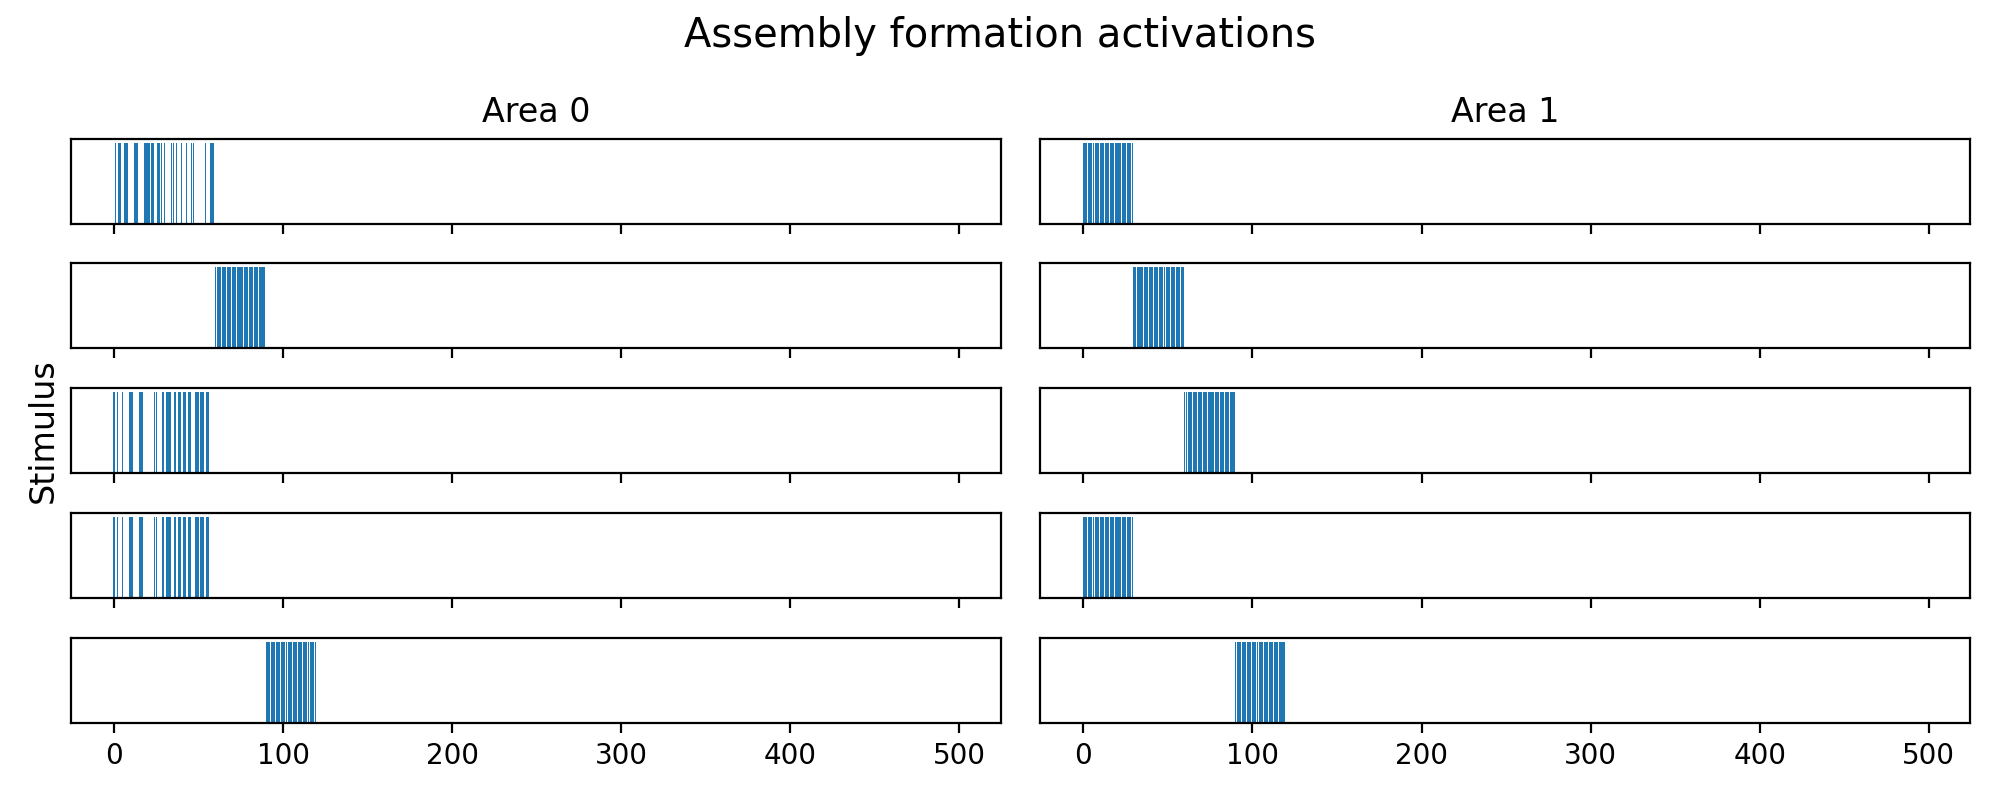

In [19]:
fig, axes = plt.subplots(seq_len, n_areas, figsize=(10, 4), sharex=True)
for j in range(n_areas):
    for i in range(seq_len):
        axes[i, j].bar(np.arange(n_neurons // 2), outputs_form[j, -1, i][idx[j, :n_neurons // 2]])
    axes[0, j].set_title('Area {}'.format(j))
axes[2, 0].set_ylabel('Stimulus', fontsize='large')
fig.suptitle('Assembly formation activations', fontsize='x-large')
    
for ax in axes.flatten():
    ax.set_yticks([])
    
fig.tight_layout()

Link consecutive assemblies in the sequence by firing the associated stimuli

In [20]:
n_rounds = 25
outputs_seq = np.zeros((n_areas, n_rounds, seq_len, n_neurons))
for area in areas:
        area.inhibit()
for i in range(n_rounds):
    for j in range(seq_len):
        for k, area in enumerate(areas):
            area.set_input(stimulus[k, j], input_area=0)
            if j > 0:
                area.set_input(areas[k-1].read(), input_area=1)
        for k, area in enumerate(areas):
            area.step()
            outputs_seq[k, i, j] = area.read()
    
    for area in areas:
        area.inhibit()

If assemblies haven't been previously formed, run the following cell to generate a sorting of the neurons from the sequence training

In [21]:
idx = (outputs_seq[:, -1] * np.arange(seq_len, 0, -1)[np.newaxis, :, np.newaxis]).sum(axis=1).argsort(axis=-1)[:, ::-1]

Plot the input and recalled activations

<IPython.core.display.Javascript object>


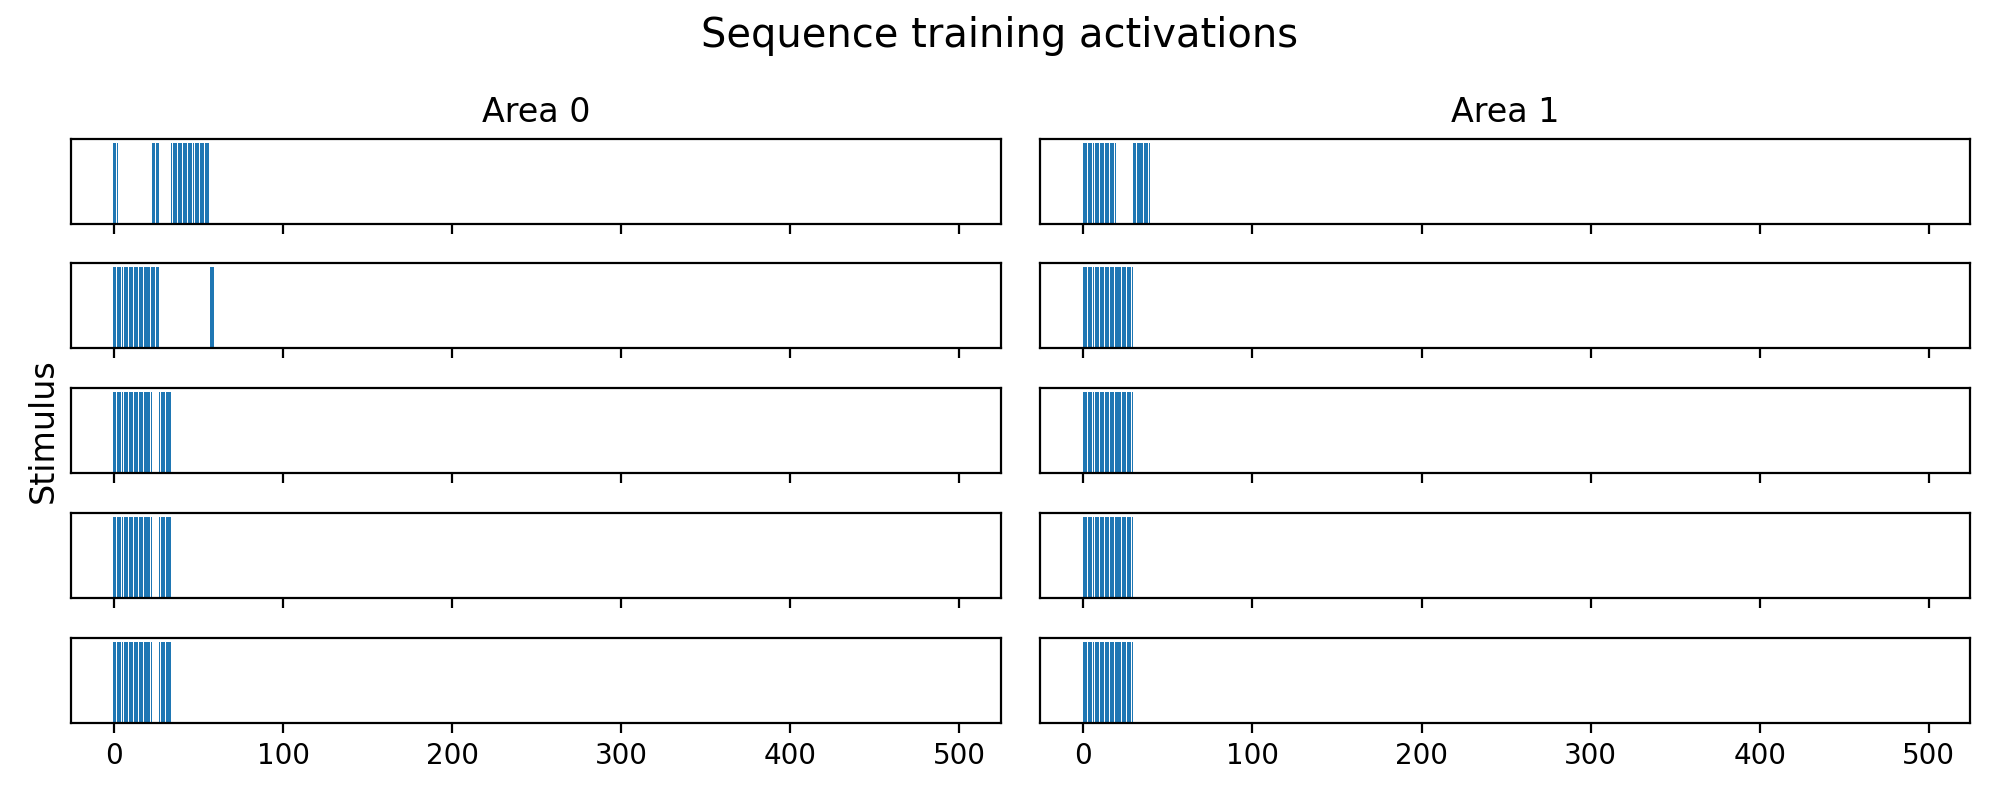

In [22]:
fig, axes = plt.subplots(seq_len, n_areas, figsize=(10, 4), sharex=True)
for j in range(n_areas):
    for i in range(seq_len):
        axes[i, j].bar(np.arange(n_neurons // 2), outputs_seq[j, -1, i][idx[j, :n_neurons // 2]])
    axes[0, j].set_title('Area {}'.format(j))
axes[2, 0].set_ylabel('Stimulus', fontsize='large')
fig.suptitle('Sequence training activations', fontsize='x-large')
    
for ax in axes.flatten():
    ax.set_yticks([])
    
fig.tight_layout()

Test recall by firing the first input to each area

In [23]:
n_rounds = seq_len
outputs_rec = np.zeros((n_areas, n_rounds, n_neurons))
for area in areas:
    area.inhibit()

for j in range(n_rounds):
    for k, area in enumerate(areas):
        if j == 0:
            area.set_input(stimulus[k, j], input_area=0)
        if j > 0:
            area.set_input(areas[k-1].read(), input_area=1)
    for k, area in enumerate(areas):
        area.step(update=False)
        outputs_rec[k, j] = area.read()
    
for area in areas:
    area.inhibit()

<IPython.core.display.Javascript object>


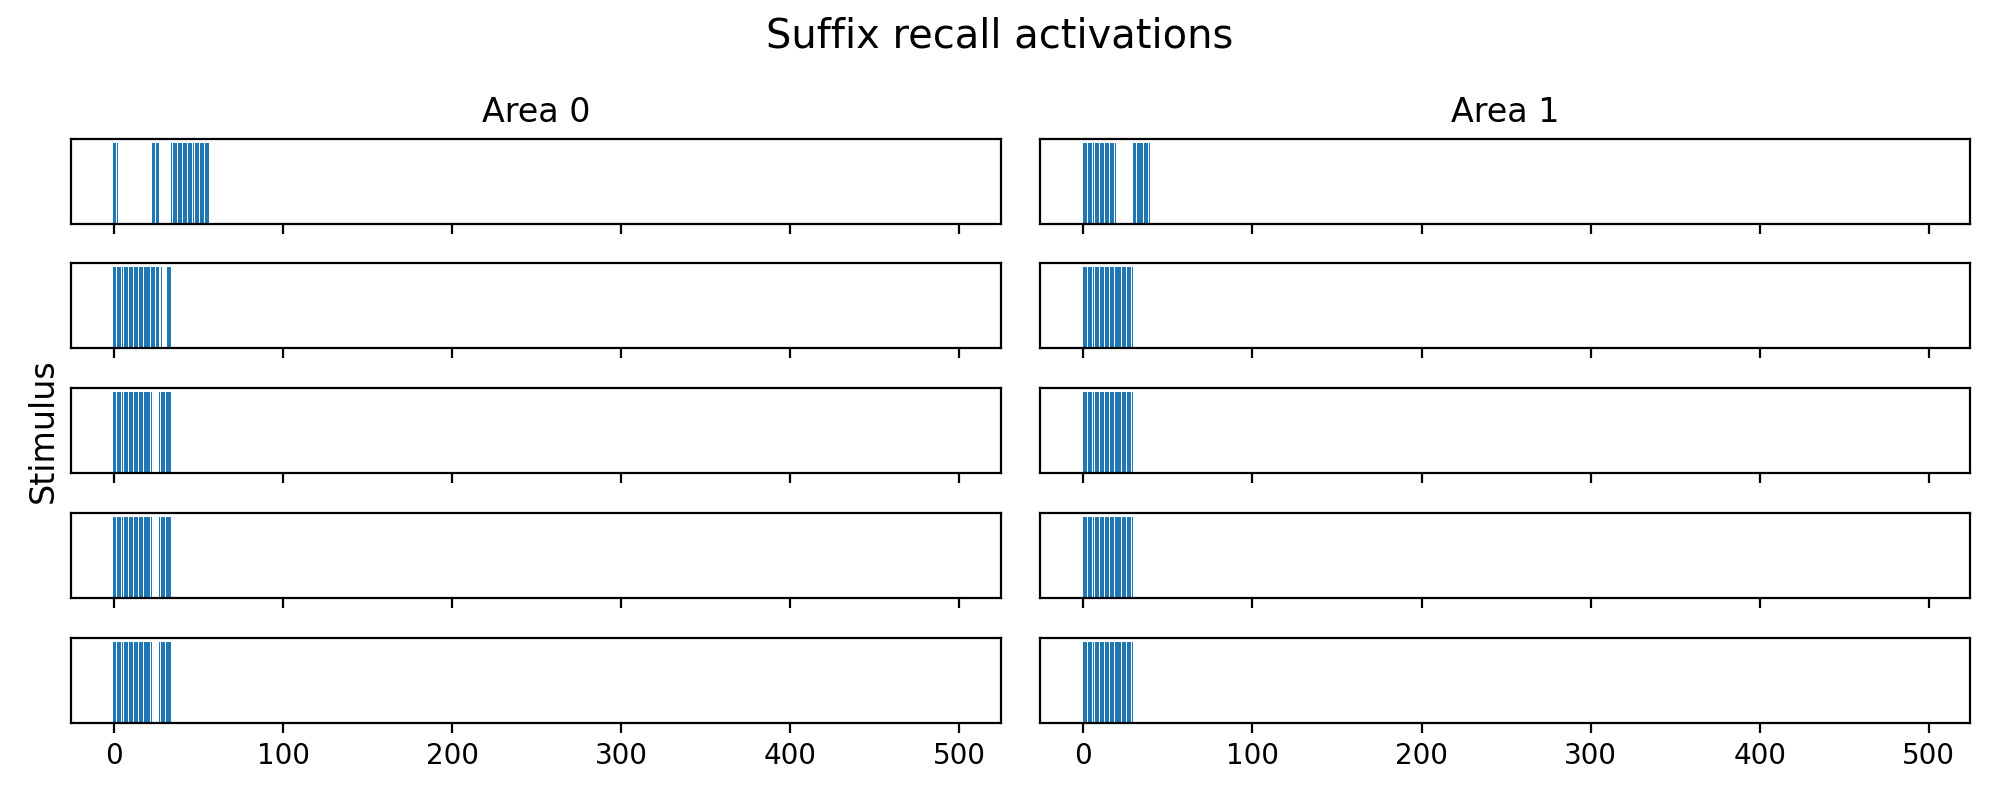

In [24]:
fig, axes = plt.subplots(seq_len, n_areas, figsize=(10, 4), sharex=True)
for j in range(n_areas):
    for i in range(seq_len):
        axes[i, j].bar(np.arange(n_neurons // 2), outputs_rec[j, i][idx[j, :n_neurons // 2]])
    axes[0, j].set_title('Area {}'.format(j))
axes[2, 0].set_ylabel('Stimulus', fontsize='large')
fig.suptitle('Suffix recall activations', fontsize='x-large')
    
for ax in axes.flatten():
    ax.set_yticks([])
    
fig.tight_layout()

Now try stimulating the first assembly in the first area, and the second assembly in the second area

In [25]:
n_rounds = seq_len
outputs_rec = np.zeros((n_areas, n_rounds, n_neurons))
for area in areas:
    area.inhibit()

for j in range(n_rounds):
    for k, area in enumerate(areas):
        if j == 0:
            area.set_input(stimulus[k, k], input_area=0)
        if j > 0:
            area.set_input(areas[k-1].read(), input_area=1)
    for k, area in enumerate(areas):
        area.step(update=False)
        outputs_rec[k, j] = area.read()
    
for area in areas:
    area.inhibit()

<IPython.core.display.Javascript object>


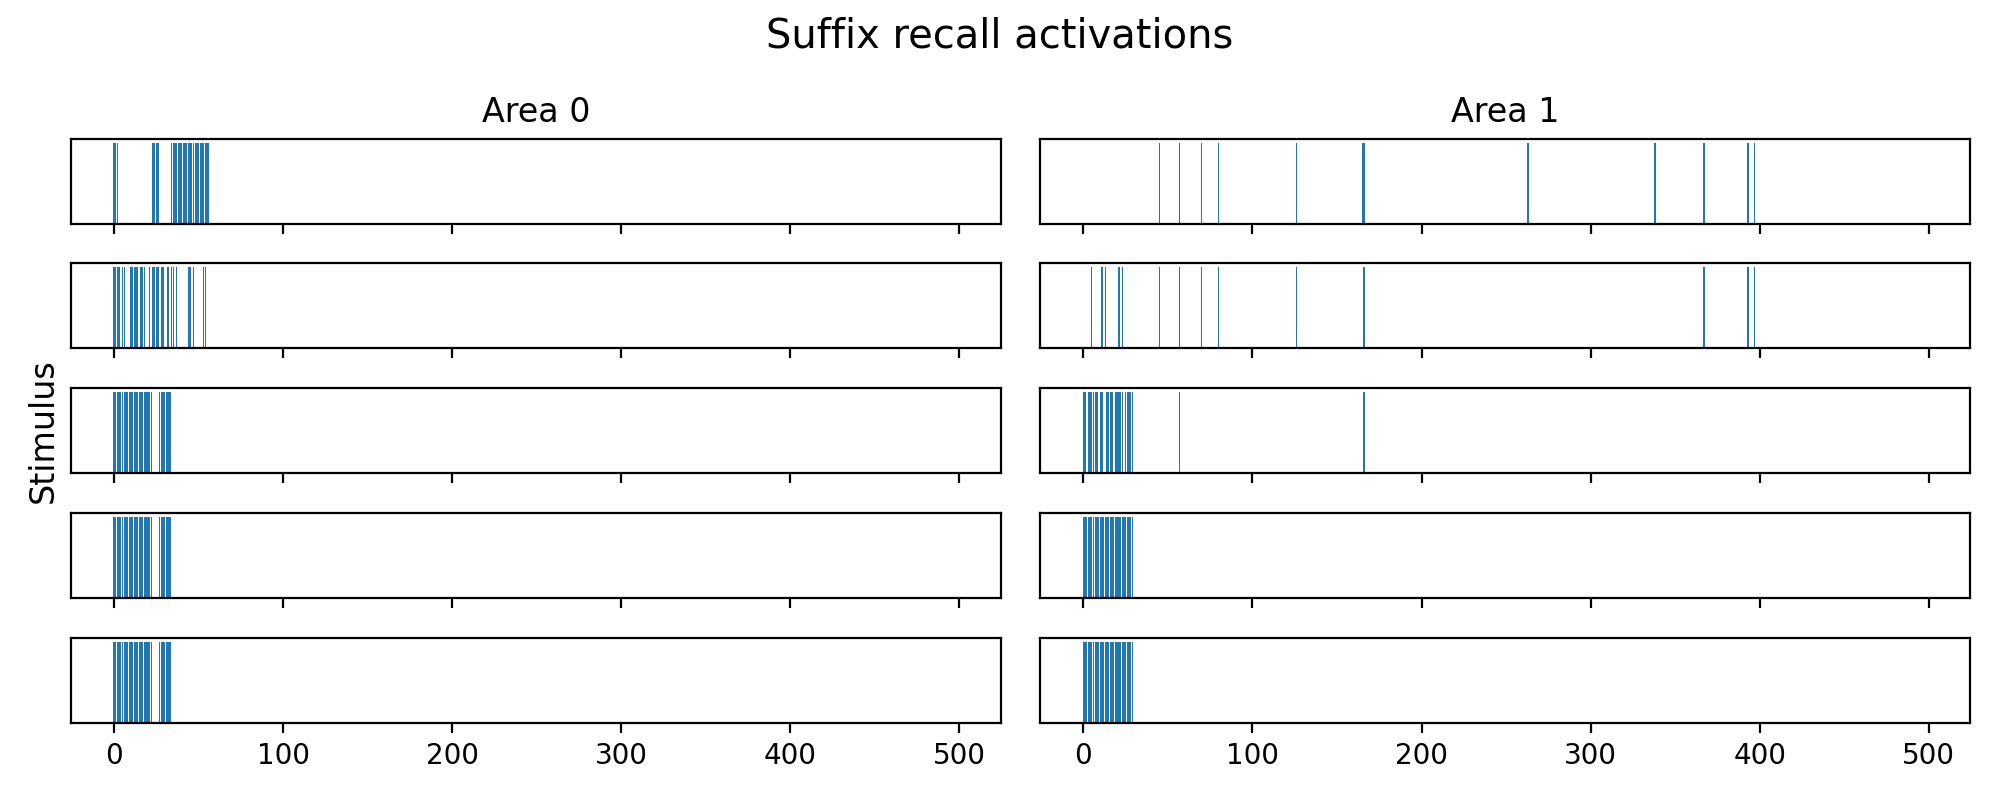

In [26]:
fig, axes = plt.subplots(seq_len, n_areas, figsize=(10, 4), sharex=True)
for j in range(n_areas):
    for i in range(seq_len):
        axes[i, j].bar(np.arange(n_neurons // 2), outputs_rec[j, i][idx[j, :n_neurons // 2]])
    axes[0, j].set_title('Area {}'.format(j))
axes[2, 0].set_ylabel('Stimulus', fontsize='large')
fig.suptitle('Suffix recall activations', fontsize='x-large')
    
for ax in axes.flatten():
    ax.set_yticks([])
    
fig.tight_layout()